# Quality control Patient_Timpoint with R

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
#pandas2ri.activate()
anndata2ri.activate()

plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

# Work with R
from rpy2.robjects import pandas2ri
%load_ext rpy2.ipython


-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.2.0
anndata             0.7.6
anndata2ri          1.0.6
attr                20.3.0
backcall            0.2.0
cached_property     1.5.2
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.2
h5py                3.2.1
idna                2.10
igraph              0.9.1
ipykernel           5.5.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
jsonschema          3.2.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.4
llvmlite            0.36.0
markupsafe          1.1.1
matplotlib          3.4.1
mpl_toolkits        NA
natsort             7.1.1
nbformat            5.1.3
numba               0.53.1
numexpr             2.7.3
numpy               1.20.2
packaging           20.9
pandas              1.2.4
pa

In [63]:
%%R
# Load all the R libraries we will be using in the notebook
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(scater)
library(cowplot)

## Cellranger output

In [64]:
%%R
# read in adata that resulted from the QC1 nb
my.data <- Read10X(data.dir = "/data/ajordano/NewBatches/data/3904/3904_MRD/outs/filtered_feature_bc_matrix")
data <- CreateSeuratObject(counts = my.data, project = "3904_MRD", min.cells = 0, min.features = 0)
data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = "^MT-")
data

In [65]:
%%R
#as data frame
df.data <- as.data.frame(my.data)
nCount <- colSums(df.data)
nGene <- colSums(df.data>0)
percent.mt <- data[["percent.mt"]] 
hba1 <- t(df.data["HBA1",])
hbb <- t(df.data["HBB",])
df <- as.data.frame(cbind(nCount, nGene, percent.mt, hba1, hbb))
dim(df)    

In [ ]:
%%R
VlnPlot(data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 2)


In [68]:
%%R
plot1 <- ggplot(df, aes(x = nCount, y = percent.mt)) + geom_point(color = "gray45") + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14))
plot2 <- ggplot(df, aes(x = nCount, y = nGene, color = percent.mt)) + geom_point(size = 2) + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot3 <- ggplot(df, aes(x = nCount, y = nGene, color = percent.mt)) + geom_point(size = 2) + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 10), low = "darkblue", high = "greenyellow")
plot_grid(plot1, plot2, plot3, ncol = 1)

### Counts

In [70]:
%%R
plot3 <- ggplot(df, aes(x=nCount)) + geom_histogram() +theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14))
plot4 <- plot3 + xlim(0, 125000) + ylim(0, 2000)
plot5 <- plot3 + xlim(0, 1000)
plot7 <- plot3 + xlim(125000, 170000)

plot_grid(plot4, plot5, plot7, ncol =1)

#### Are cells with low counts erythroid cells?

In [72]:
%%R
plot7 <- ggplot(df, aes(x = nCount, y = hbb, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot8 <- plot7 + xlim(0, 1000) + ylim(0, 1000)
plot9 <- ggplot(df, aes(x = nCount, y = hba1, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot10 <- plot9 + xlim(0, 1000) + ylim(0, 1000)
plot_grid(plot7, plot8, ncol =1)
plot_grid(plot9, plot10, ncol =1)

No cells with few counts, excluded 17 potential doublets.

### Mitochondrial percentage

In [74]:
%%R
plot1 <- ggplot(df, aes(x=percent.mt)) + geom_histogram(color = "gray") +theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14))
plot2 <- plot1 + xlim(0, 20)
plot3 <- plot1 + xlim(0, 5)
plot_grid(plot1, plot2, plot3, ncol =1)

#### Are cells with low mitochondrial percentage erythroid cells?

In [ ]:
%%R
plot7 <- ggplot(df, aes(x = percent.mt, y = hbb, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot8 <- plot7 + xlim(0, 1000) + ylim(0, 1000)
plot9 <- ggplot(df, aes(x = percent.mt, y = hba1, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot10 <- plot9 + xlim(0, 1000) + ylim(0, 1000)
plot_grid(plot7, plot8, ncol =1)
plot_grid(plot9, plot10, ncol =1)

Yes, cells with very low percentage of mito genes are red blood cells. Excluded 174 cells with more than 50% mito genes.

### Genes

In [78]:
%%R
plot1 <- ggplot(df, aes(x=nGene)) + geom_histogram() +theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14))
plot2 <- plot1 + xlim(0, 12000) + ylim(0, 2000)
plot3 <- plot1 + xlim(0, 1000)
plot4 <- plot1 + xlim(12000, 15000)
plot_grid(plot2, plot3, plot4, ncol =1)

Are cells with less than 200 genes red blood cells?

In [80]:
%%R
plot7 <- ggplot(df, aes(x = nGene, y = hbb, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot8 <- plot7 + xlim(0, 500) + ylim(0, 1500)
plot9 <- ggplot(df, aes(x = nGene, y = hba1, color = percent.mt)) + geom_point() + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot10 <- plot9 + xlim(0, 500) + ylim(0, 1500)
plot_grid(plot7, plot8, ncol =1)
plot_grid(plot9, plot10, ncol =1)

Cells with less than 200 genes are red blood cells. Didn't exclude any cells due to number of genes.

## After filtering

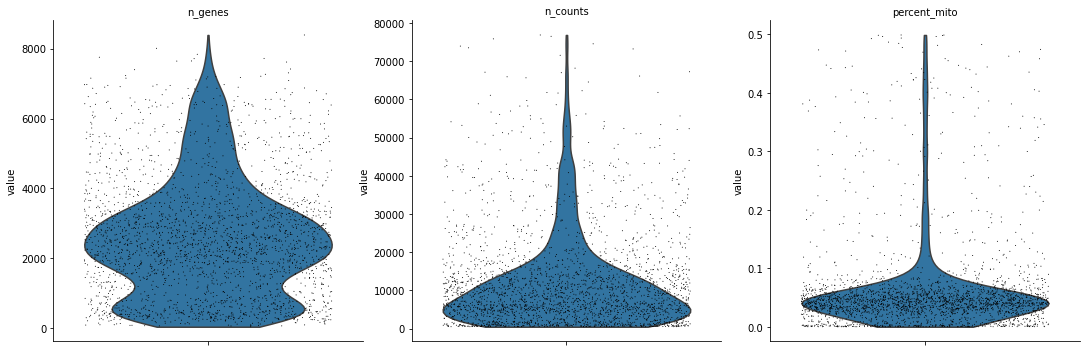

In [82]:
%%R
VlnPlot(data1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 2)

In [83]:
%%R
plot1 <- ggplot(df1, aes(x = nCount, y = percent.mt)) + geom_point(color = "gray45") + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14))
plot2 <- ggplot(df1, aes(x = nCount, y = nGene, color = percent.mt)) + geom_point(size = 3) + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 50), low = "darkblue", high = "greenyellow")
plot3 <- ggplot(df1, aes(x = nCount, y = nGene, color = percent.mt)) + geom_point(size = 2) + theme_bw() +theme(axis.text = element_text(size = 14), axis.title = element_text(size = 14)) + scale_color_gradient(limits=c(0, 10), low = "darkblue", high = "greenyellow")
plot_grid(plot1, plot2, plot3, ncol = 1)

### Conclusion

Excluded 17 potential doublets according to the number of counts, kept all red blood cells that caused a pick close to 0 percercent of mitochondrial genes, there were no empty droplets, most cells excluded were stressed or dying with percetage of mitochondrial genes higher than 50% (174). Scatter and violin plot good! Excluded 104 cells that were forming a cluster with mito genes highly expressed.

### Save file

In [90]:
%%R
SaveH5Seurat(data1, "/data/FilteredDatasets/Patient_Timepoint_cr")